In [2]:
import numpy as np
import sys
import os
import re
import shutil
from datetime import datetime, timedelta
import pandas as pd
from glob import glob
import xarray as xr
import netCDF4

sys.path.append('/p/project/cjibg36/jibg3674/eCLM_PyDA/TSMP_DA/DA')

# from setup_parameters import setup_Ks,setup_Ks_tensor,setup_Ks_anom
# from generate_parameters import generate_Ks,generate_Ks_tensor,generate_Ks_anom
from run_realization_v2 import setup_submit_wait
from DA_operators import operator_clm_SMAP, operator_clm_FLX

from settings import settings_run,settings_clm,settings_pfl,settings_sbatch,settings_DA,settings_gen,date_results_binned,freq_output,date_range_noleap

# from multiprocessing import Pool
import multiprocessing as mp

from itertools import repeat
from scipy import sparse

import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import time

from helpers import haversine_distance

os.environ['MKL_NUM_THREADS'] = '4'
os.nice(5)

5

In [3]:
def realize_parameters(i_real,settings_gen,settings_run,init=True,run_prior=False):
    dir_real = os.path.join(settings_run['dir_iter'],'R%3.3i'%i_real)
    local_state = np.random.RandomState() #required for parallel processes in python
    dir_DA = settings_run['dir_DA']

    if not os.path.exists(dir_real):
        print('Creating parameter realizations for ensemble member %i' % i_real)
        print('Creating folder for realization %i: %s' % (i_real,dir_real), flush=True )
        os.mkdir(dir_real)
        time.sleep(1)
        
        if init:
            print('Initializing parameters from prior parameter settings')
            i_iter_ = 0 #prior parameters are always read from the initial iteration file
            # Read parameter values + std, generate parameter realizations (i_real)
            for p_name, p_fn_gen in zip(settings_gen['param_names'],settings_gen['param_gen']):
                p_values = np.load(os.path.join(dir_DA,'%s.param.%3.3i.%3.3i.prior.npy'% (p_name,settings_gen['i_date'],i_iter_) ))
                p_mean = p_values[:,0]
                p_sigma = p_values[:,1]
                
                # ensemble member 0: most likely parameter values are used
                if i_real == 0 or run_prior:
                    p_real = p_mean.copy()
                else:
                    p_real = local_state.normal(p_mean,p_sigma)
                np.save(os.path.join(dir_DA,'%s.param.%3.3i.%3.3i.%3.3i'%(p_name,settings_gen['i_date'],settings_gen['i_iter'],i_real)),p_real)
                p_fn_gen(i_real,settings_gen,settings_run)
        else:
            print('Updating parameters from DA analysis')
            for p_name, p_fn_gen in zip(settings_gen['param_names'],settings_gen['param_gen']):
                print('Debug: realize_parameters, i_real %i, %s, %s' % (i_real,p_name, p_fn_gen) )
                p_fn_gen(i_real,settings_gen,settings_run)
            
def worker_realize_parameters(*args, **kwargs):
    try:
        realize_parameters(*args, **kwargs)
    except Exception as e:
        print(f"Exception in worker: {e}")
        
            
def read_parameters(n_ensemble,settings_gen,settings_run):
    # read parameter values of the different ensemble members into an array
    param_names = []
    param_latlon = np.array([])
    param_r_loc = np.array([])
    param_lengths_old = []
    for i1 in np.arange(n_ensemble):
        param_tmp = np.array([])
        
        if i1 == 0:
            for i2,p_name in enumerate(settings_gen['param_names']):
                param_ = np.load(os.path.join(settings_run['dir_DA'],'%s.param.%3.3i.%3.3i.%3.3i.npy'% (p_name,settings_gen['i_date'],settings_gen['i_iter'],i1+1) ))
                # settings_gen['param_length'][p_name] = len(param_)
                param_lengths_old.append(len(param_))
                param_tmp = np.append(param_tmp,param_)
                param_names.extend([p_name + '_%i'%int_ for int_ in np.arange(len(param_))])
                param_r_loc = np.append(param_r_loc,settings_gen['param_r_loc'][i2]*np.ones(len(param_)))
                file_latlon = os.path.join(settings_run['dir_DA'],'%s.latlon.npy'% (p_name))
                if os.path.exists(file_latlon):
                    if len(param_latlon) == 0:
                        param_latlon = np.load(file_latlon)
                    else:
                        param_latlon = np.vstack((param_latlon,np.load(file_latlon)))
                else:
                    if len(param_latlon) == 0:
                        param_latlon = np.nan*np.zeros([len(param_),2])
                    else:
                        param_latlon = np.vstack((param_latlon,np.nan*np.zeros([len(param_),2])))
            param_all = param_tmp.copy()
            
        else:
            param_lengths = []
            for i2,p_name in enumerate(settings_gen['param_names']):
                param_ = np.load(os.path.join(settings_run['dir_DA'],'%s.param.%3.3i.%3.3i.%3.3i.npy'% (p_name,settings_gen['i_date'],settings_gen['i_iter'],i1+1) ))
                param_lengths.append(len(param_))
                param_tmp = np.append(param_tmp,param_)        
            param_all = np.vstack((param_all,param_tmp))
            
            if param_lengths != param_lengths_old:
                raise RuntimeError('parameter lengths not equal\n%s\n%s' % (param_lengths,param_lengths_old))
                
    return param_all.T,param_names,param_latlon,param_r_loc


def write_parameters(parameters,settings_gen,settings_run):
    dir_DA = settings_run['dir_DA']
    for i_real in range(parameters.shape[1]):
        i_start = 0
        for p_name in settings_gen['param_names']:
            i_end = i_start + settings_gen['param_length'][p_name] 
            param_ = parameters[i_start:i_end,i_real]
            np.save(os.path.join(dir_DA,'%s.param.%3.3i.%3.3i.%3.3i'%(p_name,settings_gen['i_date'],settings_gen['i_iter']+1,i_real+1)),param_)
            i_start = i_end
            
    # write mean parameter values to member 0
    i_start = 0
    for p_name in settings_gen['param_names']:
        i_end = i_start + settings_gen['param_length'][p_name] 
        param_ = parameters[i_start:i_end,:].mean(axis=1)
        np.save(os.path.join(dir_DA,'%s.param.%3.3i.%3.3i.%3.3i'%(p_name,settings_gen['i_date'],settings_gen['i_iter']+1,0)),param_)
        i_start = i_end   
        
def change_setting(filename, key, new_value):
    # Escape special characters in the key
    escaped_key = re.escape(key)

    # Define the pattern to match
    pattern = re.compile(r"('{}'\s*:\s*)(.+?)(?=[,}}])".format(escaped_key))

    # Read the content of the file
    with open(filename, 'r') as file:
        content = file.read()

    # Use the pattern to find and replace the matched value
    content = pattern.sub(r"\g<1>{}".format(new_value), content)

    # Write the updated content back to the file
    with open(filename, 'w') as file:
        file.write(content)
        
def check_for_success(dir_iter,dir_DA,dir_settings,date_results_iter,n_ensemble):
        
    date_start_sim = date_results_iter[-1][0]
    date_end_sim = date_results_iter[-1][-1]
    str_date = str(date_start_sim.date()).replace('-','') + '-' + str(date_end_sim.date()).replace('-','')
    all_success = False
    reread_required = False

    ## Following function should be called iteratively until np.all(flag_success) = True
    while not all_success:
        reread_required = True
        i_source = n_ensemble #which directory to move in case one of the runs failed

        flag_success = np.zeros(n_ensemble,dtype=bool)
        for i1 in range(1,n_ensemble+2):
            restart_file = glob(os.path.join(dir_iter,'R%3.3i/run_%s/*.clm2.r.*.nc'%(i1,str_date)))
            print('Restart file: %i, %s' %(i1,restart_file) )
            if len(restart_file) > 0:
                flag_success[i1-1] = True


        # if the last run failed, remove it
        while flag_success[-1] == False:
            # remove last folder
            shutil.rmtree(os.path.join(dir_iter,'R%3.3i'%(i_source)), ignore_errors = True) 
            # remove last index flag
            flag_success = np.delete(flag_success,-1)
            i_source -= 1
            n_ensemble -= 1

        if not np.all(flag_success):
            i_dest = np.where(~flag_success)[0][0]+1 

            print('-----------------Important!!!!!-----------------')
            print('Moving R%3.3i to R%3.3i (failed run)' %(i_source,i_dest) )
            print('-----------------Important!!!!!-----------------')

            paramfiles_source = sorted(glob(os.path.join(dir_DA,'*.%3.3i.npy'%i_source)))
            paramfiles_source_tmp = sorted([file_ + '_old' for file_ in paramfiles_source])
            paramfiles_dest = sorted(glob(os.path.join(dir_DA,'*.%3.3i.npy'%i_dest)))
            paramfiles_dest_tmp = sorted([file_ + '_old' for file_ in paramfiles_dest])

            shutil.move(os.path.join(dir_iter,'R%3.3i'%i_dest),os.path.join(dir_iter,'R%3.3i_old'%i_dest) )
            shutil.move(os.path.join(dir_iter,'R%3.3i'%i_source),os.path.join(dir_iter,'R%3.3i'%i_dest) )

            for file_src_in,file_src_out,file_dest_in,file_dest_out in zip(paramfiles_source,paramfiles_source_tmp,paramfiles_dest,paramfiles_dest_tmp):
                shutil.move(file_dest_in,file_dest_out) #move failed parameter file (e.g. 13) to 13_old
                shutil.copy(file_src_in,file_src_out) #copy the successfull parameter file (e.g. 16) to 16_old
                shutil.move(file_src_in,file_dest_in) #move the successfull paramfile (e.g. 16) to 13

            n_ensemble -=1

        else:
            all_success = True
            
    if not reread_required:
        print('Simulations were all successfull, all restart files available')
    else:
        change_setting(os.path.join(dir_settings,'settings.py'),'n_ensemble',n_ensemble)
        
    return n_ensemble, reread_required

def mask_observations(data_names,data_measured,data_var,data_latlon,data_nselect,data_mask,factor_inflate=1.):
    data_indices = {}
    i_start = 0
    i_end = np.inf
    
    # print(factor_inflate)
    n_vars = len(data_names)
    if type(factor_inflate) == float:
        var_inflate = {var_ : factor_inflate for var_ in data_names}
    elif type(factor_inflate) == dict:
        var_inflate = factor_inflate.copy()
    else:
        raise RuntimeError('type should be float or dict')
        
    for i1,var_ in enumerate(data_names):
        # print(var_,data_var[var_],var_inflate[var_])
        data_var[var_] *= var_inflate[var_]
        
        n_select = data_nselect[var_]
        if len(data_measured[var_]) < n_select:
            data_mask[var_] = np.ones(len(data_measured[var_]),dtype=bool)
            n_select = len(data_measured[var_])
        else:
            frac_select = min((n_select / len(data_measured[var_])),.99)
            data_mask[var_] = np.random.choice([0,1],size=len(data_measured[var_]),p=[1-frac_select,frac_select]).astype(bool) 
            n_select = int(data_mask[var_].sum())
        i_end = i_start + n_select
        data_indices[var_] = [i_start,i_end]

        if i1 == 0:
            data_measured_masked = data_measured[var_][data_mask[var_]].copy()
            data_latlon_masked = data_latlon[var_][data_mask[var_]].copy()
            if type(data_var[var_]) == float:
                data_var_masked = data_var[var_]*np.ones(n_select)
            else:
                data_var_masked = data_var[var_][data_mask[var_]].copy()
        else:
            data_measured_masked = np.append(data_measured_masked,data_measured[var_][data_mask[var_]])
            data_latlon_masked = np.vstack((data_latlon_masked,data_latlon[var_][data_mask[var_]]))
            if type(data_var[var_]) == float:
                data_var_masked = np.append(data_var_masked,data_var[var_]*np.ones(n_select))
            else:
                data_var_masked = np.append(data_var_masked,data_var[var_][data_mask[var_]])

        i_start = i_end
        print('Thinned out %s observations: %i -> %i' % (var_,len(data_measured[var_]),n_select))

    n_data = i_end
    # data_var_masked*=factor_inflate
    return data_mask,data_indices,n_data,data_measured_masked,data_var_masked,data_latlon_masked



def plot_prior_post(param_f,param_a,param_names_all,i_iter,dir_figs=os.path.join('.','params') ):
    if not os.path.exists(dir_figs):
        print('Creating folder to store parameter update figures: %s' % (dir_figs) )
        os.mkdir(dir_figs)
    c = 0
    c2 = 0
    n_param_max = 16*100 #max 100 plots
    n_param = min(len(param_f),n_param_max)
    n_figs = np.ceil(n_param/16).astype(int)

    for i_ in np.arange(n_param):
        if i_ % 16 == 0:
            c = 0
            fig,axes=plt.subplots(4,4,figsize=(8,7))
        row_ = c//4
        col_ = c%4

        axes[row_,col_].plot(param_f[i_,:],np.zeros(param_f[i_,:].shape),'ko')
        axes[row_,col_].plot(param_a[i_,:],np.zeros(param_a[i_,:].shape),'rx')
        axes[row_,col_].set_title(param_names_all[i_])
        c += 1
        if c == 16 or i_ == n_param-1:
            fig.suptitle('Iter %i -> %i' %(i_iter,i_iter+1))
            fig.tight_layout()
            fig.savefig(os.path.join(dir_figs,'params_i%3.3i_%3.3i.png'%(i_iter,c2)) )
            c2 += 1

            
def update_step_ESMDA(param_f,data_f,data_measured,data_var,alpha,i_iter):
    print('Calculating KG and performing parameter update...')
    assert data_f.shape[0] == len(data_measured)
    n_data_ = data_f.shape[0]
    n_ensemble = data_f.shape[1]
    n_param = param_f.shape[0]
    
    # 3) construct covariance matrices based on ensemble of parameters and results (data)
    # C_D = data_var['SMAP']*sparse.eye(n_data) 
    C_D = sparse.diags(data_var)
    C_MD = np.zeros([n_param,n_data_],dtype=np.float32)
    C_DD = np.zeros([n_data_,n_data_],dtype=np.float32)
    param_mean = param_f.mean(axis=1)
    data_mean = data_f.mean(axis=1)        
    param_delta = np.zeros([n_param,n_ensemble])
    data_delta = np.zeros([n_data_,n_ensemble])
    for i2 in range(n_ensemble):
        param_delta[:,i2] = param_f[:,i2] - param_mean
        data_delta[:,i2] = data_f[:,i2] - data_mean

        C_MD += np.outer(param_delta[:,i2],data_delta[:,i2])
        C_DD += np.outer(data_delta[:,i2],data_delta[:,i2])
    C_MD /= (n_ensemble - 1)
    C_DD /= (n_ensemble - 1)

    # Kalman Gain matrix:
    KG = np.dot(C_MD,np.linalg.inv(C_DD + alpha[i_iter]*C_D)) 

    # 4) update the parameters
    param_a = np.zeros([n_param, n_ensemble])
    mean_mismatch_new = 0
    for i_real in range(n_ensemble):

        z_d = np.random.normal(0,1,n_data_)
        data_perturbed = data_measured + np.sqrt(alpha[i_iter])*np.sqrt(C_D.diagonal())*z_d

        mismatch = data_perturbed - data_f[:,i_real]

        mean_mismatch_new += np.sum(mismatch**2)

        # forecast -> analysis
        param_a[:,i_real] = param_f[:,i_real] + np.dot(KG,mismatch)

    mean_mismatch_new /= n_ensemble
    
    return param_a, mean_mismatch_new

def update_step_ESMDA_loc(mat_M,mat_D,data_measured,data_var,alpha,i_iter,n_iter,
                          param_latlon=None,param_r_loc=None,data_latlon=None,ksi=.99,
                          dzeta_global=1.,dir_settings='.',factor_inflate_prior=1.,loc_type='distance',POL_eps=.5):
    """
    Optimized version for many observations
    Possibility to include localisation
    
    Based on appendix of Emerick (2016), j. of Petroleum Science and Engineering 
    doi.org/10.1016/j.petrol.2016.01.029
    """

    def calculate_alphas(lambda_Wd_,n_iter):
        """
        Based on Rafiee and Reynolds, 2017 (Hankes regularization condition)
        Calculate set of inflation factors
        """
        if n_iter == 1:
            alphas = [1]
        else:
            try:
                from scipy.optimize import minimize_scalar
                def f1(gamma,alpha_1,N_a):
                        sum_ = 0
                        for i in range(N_a):
                            k= i+1
                            if ( (gamma**(k-1)) * alpha_1) == 0:
                                print(gamma,k,alpha_1)
                            sum_ += (1/ ( (gamma**(k-1)) * alpha_1) )

                        return (sum_ - 1)**2

                rho = .5
                alpha_1 = max((rho/(1-rho))*lambda_Wd_.mean()**2,n_iter)

                res = minimize_scalar(f1,bounds=(0.001,0.999),bracket=(0.001,0.999),args=(alpha_1,n_iter))
                gamma = res.x

                alphas = [(gamma**k)*alpha_1 for k in np.arange(n_iter)]
                print('Inflation factors (alpha) calculated:',alphas)
            except:
                print('Inflation factor (alpha) calculation failed, falling back to alpha=n_iter')
                alphas = [n_iter for k in np.arange(n_iter)]

            assert( np.sum(1/np.array(alphas))-1 < 1e-5)

        return alphas

    print('Calculating KG and performing parameter update...', flush=True)
    print('Using %s localisation' % loc_type)
    assert mat_D.shape[0] == len(data_measured)

    n_data_ = mat_D.shape[0]
    n_ensemble = mat_D.shape[1]
    n_param = mat_M.shape[0]

    C_D = sparse.diags(data_var)

    del_M = (1/np.sqrt(n_ensemble-1))*(mat_M - mat_M.mean(axis=1)[:,np.newaxis])
    del_D = (1/np.sqrt(n_ensemble-1))*(mat_D - mat_D.mean(axis=1)[:,np.newaxis])

    del_D *= factor_inflate_prior
    
    S = sparse.diags(C_D.diagonal()**(1/2))
    C_Dh = 1.*sparse.eye(n_data_)
    Sinv = sparse.diags(1/S.diagonal()) #inverse of diagonal matrix: simply the reciprocal

    Ud, lambda_Wd, Vdt = np.linalg.svd(Sinv.dot(del_D), full_matrices=False)
    assert(np.all(lambda_Wd[:-1] > lambda_Wd[1:])) #assert that the eigenvalues are sorted

    if alpha is None:
        print('Calculating inflation factors alpha...', flush=True)
        alpha = calculate_alphas(lambda_Wd,n_iter)
        print(alpha, flush=True)
        change_setting(os.path.join(dir_settings,'settings.py'),'alpha',alpha)
        
    cumsum_wr = np.cumsum(lambda_Wd) / np.sum(lambda_Wd)
    Nr = max(len(lambda_Wd)//2, np.where(cumsum_wr<=ksi)[0][-1]) #take Nr most important singular values, retain at least half the original matrix size just in case

    Ur = Ud[:,0:Nr]
    Wr = sparse.diags(lambda_Wd[0:Nr])
    Vrt = Vdt[0:Nr,0:Nr]
    Ir = sparse.eye(Nr)
    Wrinv = sparse.diags(1/Wr.diagonal()) 

    mat_R = alpha[i_iter]*(Wrinv @ Ur.T @ C_Dh @ Ur @ Wrinv)

    Zr, lambda_Hr, Zrt = np.linalg.svd(mat_R, full_matrices=False)
    Hr = sparse.diags(lambda_Hr)

    mat_X = Sinv @ Ur @ Wrinv @ Zr
    mat_L = Ir + Hr
    mat_Linv = sparse.diags(1/mat_L.diagonal()) 

    mat_X1 = mat_Linv @ mat_X.T
    mat_X2 = del_D.T @ mat_X
    mat_X3 = mat_X2 @ mat_X1

    # perturb observations, at the same time calculate the mismatch of the current forecast
    mat_Dobs = np.zeros(mat_D.shape)
    mean_mismatch_new = 0
    for i_real in range(n_ensemble):
        z_d = np.random.normal(0,1,n_data_)
        mat_Dobs[:,i_real] = data_measured + np.sqrt(alpha[i_iter])*np.sqrt(C_D.diagonal())*z_d
        mismatch = mat_Dobs[:,i_real] - mat_D[:,i_real]
        mean_mismatch_new += np.sum(mismatch**2)
    mean_mismatch_new /= n_ensemble
    
    sum_d_localized = 0
    sum_d_global = 0
    n_param_localized_tot = 0
    # calculate updated (analysis) parameters
    
    # used for POL localisation:
    c_ii = np.var( (mat_M - mat_M.mean(axis=1)[:,np.newaxis]), axis=1, ddof=1) #(n_param,) -> estimate of C_M
    c_jj = np.var( (mat_D - mat_D.mean(axis=1)[:,np.newaxis]), axis=1, ddof=1) #(n_data,) -> estimate of C_D

    param_a = np.zeros(mat_M.shape)
    for i in range(n_param):
        
        # first localisation option: distance based, by using haversine distance & GC function
        if loc_type == 'distance':    
            if np.isnan(param_r_loc[i]):
                rho_i = dzeta_global*np.ones(n_data_) #no localisation
            else:
                r_loc = param_r_loc[i]
                # localisation using the Gaspari-Cohn localisation function:
                rho_i = GC(haversine_distance(param_latlon[i,:],data_latlon),r_loc)
        # second option: pseudo optimal localization
        # see e.g. Lacerda et al. (2019), Furrer et al. (2007)
        elif loc_type == 'POL':
            ci = del_M[i,:]@(del_D[:,:].T)
            rho_i = ci**2 / (ci**2 + (ci**2+(c_ii[i]*c_jj)/n_ensemble) )
            mask_zero = np.abs(ci) < POL_eps*np.sqrt(c_ii[i]*c_jj)
            rho_i[mask_zero] = 0
            
        else:
            print('Warning!! Localisation method unknown. Set to POL or distance')
            rho_i = np.ones(n_data_)

            
        K_i = del_M[i,:]@mat_X3
        K_rho_i = K_i * rho_i
        mat_X4 = K_rho_i @ (mat_Dobs - mat_D)
        param_a[i,:] = mat_M[i,:] + mat_X4
 
    return param_a, mean_mismatch_new, alpha


def GC(r, c):
    #Gaspari-Cohn localization function
    abs_r = np.abs(r)
    if np.isnan(c):
        result = np.ones_like(abs_r, dtype=float)
    else:
        condition1 = (0 <= abs_r) & (abs_r <= c)
        condition2 = (c <= abs_r) & (abs_r <= 2 * c)

        result = np.zeros_like(abs_r, dtype=float)

        result[condition1] = -1/4 * (abs_r[condition1] / c) ** 5 + 1/2 * (abs_r[condition1] / c) ** 4 + 5/8 * (abs_r[condition1] / c) ** 3 - \
                            5/3 * (abs_r[condition1] / c) ** 2 + 1
        result[condition2] = 1/12 * (abs_r[condition2] / c) ** 5 - 1/2 * (abs_r[condition2] / c) ** 4 + 5/8 * (abs_r[condition2] / c) ** 3 + \
                            5/3 * (abs_r[condition2] / c) ** 2 - 5 * (abs_r[condition2] / c) + 4 - 2/3 * (c / abs_r[condition2])

    return result



# if __name__ == '__main__':

# which data to assimilate: 
data_names = settings_DA['data_names']
# If uncertainties are assumed constant, prescribe:
# data_var = {'SMAP':0.04**2,
#             'FLX':None}
data_var = settings_DA['data_var']


In [46]:
import sys
folder_results = '/p/scratch/cjibg36/jibg3674/CLM5_DA/small_test_ap'
if folder_results not in sys.path:
    sys.path.insert(0,os.path.join(folder_results,'settings'))
import settings
importlib.reload(settings)
from settings import settings_run,settings_clm,settings_pfl,settings_sbatch,settings_DA,settings_gen,date_results_binned,freq_output,date_range_noleap

settings_run['remove_hist_files'] = ['h1','h2']

In [52]:
plot_members_SMAP = 0 #set to int (iteration for which to plot members), or to False/True
plot_members_FLX = True

# which data to assimilate: 
data_names = settings_DA['data_names']
data_var = {'SMAP':0.04**2,
            'FLX':None}

data_mask = {'SMAP':None, #initialize dict
             'FLX':None}


# prescribe_alpha = settings_DA['prescribe_alpha']
alpha = settings_DA['alpha']
factor_inflate = settings_DA['factor_inflate']
factor_inflate_prior = settings_DA['factor_inflate_prior']
ksi=settings_DA['cutoff_svd']

### Unpack some of the settings into variables
# Functions that are run to initialize the parameters to be assimilated. 
# E.g. for spatial parameter fields, initialize the static fields (x,y,z) locations and the prior/uncertainty estimates
param_setup = settings_DA['param_setup'] 
# Functions that are run to generate realizations of parameters/state variables
param_gen   = settings_DA['param_gen']
# Define parameter names; parameters values are stored in (%s.param.npy % param_name) files
param_names = settings_DA['param_names']

# possibility to only select a limited amount of observations using masks
data_nselect = settings_DA['n_data_max']

n_parallel = settings_DA['n_parallel']
n_parallel_setup = settings_DA['n_parallel_setup']
n_ensemble = settings_DA['n_ensemble']
n_iter = settings_DA['n_iter']
dir_setup = settings_run['dir_setup']
dir_template = settings_run['dir_template']
atm_perb = settings_run['atm_perb']


In [6]:
dir_setup

'/p/scratch/cjibg36/jibg3674/CLM5_DA/small_test_ap'

In [53]:

'''
 1) Copy the folder template to the setup location if the destination does not exist
'''
if not os.path.exists(dir_setup):
    print('Copying folder template from %s to %s' % (dir_template,dir_setup) )
    shutil.copytree(dir_template,dir_setup)
else:
    print('Continuing simulation in %s' % dir_setup)
# os.chdir(dir_setup)

# copy settings file for later use
dir_settings = os.path.join(settings_run['dir_setup'],'settings')
if not os.path.exists(dir_settings):
    os.mkdir(dir_settings)
    shutil.copy('/p/project1/cjibg36/jibg3674/eCLM_PyDA/TSMP_DA/DA/settings.py',dir_settings)

dir_figs = os.path.join(dir_setup,'figures')
settings_run['dir_figs'] = dir_figs
if not os.path.exists(dir_figs):
    print('Creating folder to store DA information: %s' % (dir_figs) )
    os.mkdir(dir_figs)

dir_DA = os.path.join(dir_setup,'input_DA')
settings_run['dir_DA'] = dir_DA
if not os.path.exists(dir_DA):
    print('Creating folder to store DA information: %s' % (dir_DA) )
    os.mkdir(dir_DA)

    # setup parameters: prior/uncertainties, + static properties, lon/lat locations based on the settings if necessary
    for fn in param_setup:
        fn(settings_gen,settings_run)

# Read parameter length and put in dictionary here
for param_ in param_names:
    settings_gen['param_length'][param_] = np.load(os.path.join(dir_DA,'%s.param.000.000.prior.npy' % param_) ).shape[0]

#%% ----------- DA loop -----------


#%% ----------- date loop -----------    
# this comes in the date loop, e.g. perform the smoother over a period over 1 year:
i_date = 0
date_results_iter = date_results_binned[i_date].copy()
date_start_sim = date_results_binned[i_date][0][0]#datetime(2019,1,2,12,0,0)
date_end_sim = date_results_binned[i_date][-1][-1]#datetime(2019,12,31,12,0,0)

# add spinup if necessary:
if settings_run['ndays_spinup'] is not None:
    date_results_iter.insert(0,list(date_range_noleap(date_start_sim-timedelta(days=settings_run['ndays_spinup']),date_start_sim,periods=2)))


str_date = str(date_start_sim.date()).replace('-','') + '-' + str(date_end_sim.date()).replace('-','')
dir_date = os.path.join(dir_setup,str_date)
if not os.path.exists(dir_date):
    print('Creating folder for dates %s: %s' % (str_date,dir_date) )
    os.mkdir(dir_date)

Continuing simulation in /p/scratch/cjibg36/jibg3674/CLM5_DA/small_test_ap


In [54]:
mismatch_iter = [0]
i_iter = 0
init = True

str_iter = 'i%3.3i' % i_iter
dir_iter = os.path.join(dir_date,str_iter)
if os.path.exists(os.path.join(dir_DA,'%s.param.000.%3.3i.000.npy'%(param_names[0],i_iter+1)) ): #check if the next iteration parameter files already exist
    print('Iteration %i seems to have finished succesfully, continuing with the next iteration...' % i_iter)
else:
    if not os.path.exists(dir_iter):
        print('Creating folder for iteration %i: %s' % (i_iter,dir_iter) )
        os.mkdir(dir_iter)
        
settings_run['dir_iter'] = dir_iter
settings_gen['i_date'] = i_date
settings_gen['i_iter'] = i_iter
settings_gen['param_gen'] = param_gen
settings_gen['param_names'] = param_names
settings_gen['param_r_loc'] = settings_DA['param_r_loc']

for i_real in np.arange(0,n_ensemble+1):
    realize_parameters(i_real,settings_gen,settings_run,init=init)

In [55]:
print('n_ensemble: %i' % n_ensemble, flush=True)
# Aggregrate all parameter values into param_f
param_f,param_names_all,param_latlon,param_r_loc = read_parameters(n_ensemble,settings_gen,settings_run)
n_param = len(param_f)
print('Amount of parameters to assimilate: %i' % n_param, flush=True)

n_ensemble: 3
Amount of parameters to assimilate: 1294


In [72]:
import importlib
import run_realization_v2
importlib.reload(run_realization_v2)
from run_realization_v2 import setup_submit_wait

In [73]:
with mp.Pool(processes=n_parallel) as pool:
    pool.starmap(setup_submit_wait, zip(np.arange(0,n_ensemble+1),repeat(settings_run),repeat(settings_clm),
                                       repeat(settings_pfl),repeat(settings_sbatch),repeat(date_results_iter),repeat(n_ensemble)) )



Restarting run from /p/project/cjibg36/jibg3674/shared_DA/EU11.clm2.r.2019-01-01-00000.nc and FalseRestarting run from /p/project/cjibg36/jibg3674/shared_DA/EU11.clm2.r.2019-01-01-00000.nc and False
Restarting run from /p/project/cjibg36/jibg3674/shared_DA/EU11.clm2.r.2019-01-01-00000.nc and FalseRestarting run from /p/project/cjibg36/jibg3674/shared_DA/EU11.clm2.r.2019-01-01-00000.nc and False


Preparing simulation in /p/scratch/cjibg36/jibg3674/CLM5_DA/small_test_ap/20190501-20190531/i000/R001/run_20190302-20190501Preparing simulation in /p/scratch/cjibg36/jibg3674/CLM5_DA/small_test_ap/20190501-20190531/i000/R002/run_20190302-20190501Preparing simulation in /p/scratch/cjibg36/jibg3674/CLM5_DA/small_test_ap/20190501-20190531/i000/R000/run_20190302-20190501Preparing simulation in /p/scratch/cjibg36/jibg3674/CLM5_DA/small_test_ap/20190501-20190531/i000/R003/run_20190302-20190501



Copy binaries from /p/project1/cjibg36/jibg3674/eCLM_PyDA/eCLM/eclm/bin/
Copy binaries from /p/project1/


  This stage is deprecated. Please consider moving to a new stage (2024
or newer)


  This stage is deprecated. Please consider moving to a new stage (2024
or newer)


  This stage is deprecated. Please consider moving to a new stage (2024
or newer)


  This stage is deprecated. Please consider moving to a new stage (2024
or newer)


The following have been reloaded with a version change:
  1) HDF5/1.12.2 => HDF5/1.12.2-serial


The following have been reloaded with a version change:
  1) HDF5/1.12.2 => HDF5/1.12.2-serial


The following have been reloaded with a version change:
  1) HDF5/1.12.2 => HDF5/1.12.2-serial


The following have been reloaded with a version change:
  1) HDF5/1.12.2 => HDF5/1.12.2-serial


The following have been reloaded with a version change:
  1) HDF5/1.12.2-serial => HDF5/1.12.2


The following have been reloaded with a version change:
  1) HDF5/1.12.2-serial => HDF5/1.12.2


The following have been reloaded with a version change:
  1) HDF5/1.12.2-serial =

Still running (['20190501-20190531', 'i000', 'R003'])...
Submitted batch job 10183192
Still running (['20190501-20190531', 'i000', 'R000'])...
Still running (['20190501-20190531', 'i000', 'R001'])...
Submitted batch job 10183193
Submitted batch job 10183194
Still running (['20190501-20190531', 'i000', 'R002'])...
Submitted batch job 10183195
Still running (['20190501-20190531', 'i000', 'R003'])...
Still running (['20190501-20190531', 'i000', 'R000'])...
Still running (['20190501-20190531', 'i000', 'R001'])...
Still running (['20190501-20190531', 'i000', 'R002'])...
Still running (['20190501-20190531', 'i000', 'R003'])...
Still running (['20190501-20190531', 'i000', 'R000'])...
Still running (['20190501-20190531', 'i000', 'R001'])...
Still running (['20190501-20190531', 'i000', 'R002'])...
Still running (['20190501-20190531', 'i000', 'R003'])...
Still running (['20190501-20190531', 'i000', 'R000'])...
Still running (['20190501-20190531', 'i000', 'R001'])...
/p/scratch/cjibg36/jibg3674/C

Traceback (most recent call last):
  File "/p/project1/cjibg36/jibg3674/eCLM_PyDA/TSMP_DA/DA/run_realization_v2.py", line 637, in setup_submit_wait
    print(files_clm_restart[-1].split('.'))
IndexError: list index out of range


/p/scratch/cjibg36/jibg3674/CLM5_DA/small_test_ap/20190501-20190531/i000/R003/run_20190302-20190501
['/p/scratch/cjibg36/jibg3674/CLM5_DA/small_test_ap/20190501-20190531/i000/R003/run_20190302-20190501/EU11.clm2.r.2019-05-01-00000.nc']
['/p/scratch/cjibg36/jibg3674/CLM5_DA/small_test_ap/20190501-20190531/i000/R003/run_20190302-20190501/EU11', 'clm2', 'r', '2019-05-01-00000', 'nc']
Restarting CLM from /p/scratch/cjibg36/jibg3674/CLM5_DA/small_test_ap/20190501-20190531/i000/R003/run_20190302-20190501/EU11.clm2.r.2019-05-01-00000.nc
Preparing simulation in /p/scratch/cjibg36/jibg3674/CLM5_DA/small_test_ap/20190501-20190531/i000/R003/run_20190501-20190531
Copy binaries from /p/project1/cjibg36/jibg3674/eCLM_PyDA/eCLM/eclm/bin/
/p/scratch/cjibg36/jibg3674/CLM5_DA/small_test_ap/20190501-20190531/i000/R000/run_20190302-20190501
['/p/scratch/cjibg36/jibg3674/CLM5_DA/small_test_ap/20190501-20190531/i000/R000/run_20190302-20190501/EU11.clm2.r.2019-05-01-00000.nc']
['/p/scratch/cjibg36/jibg3674/C


  This stage is deprecated. Please consider moving to a new stage (2024
or newer)


  This stage is deprecated. Please consider moving to a new stage (2024
or newer)


  This stage is deprecated. Please consider moving to a new stage (2024
or newer)


The following have been reloaded with a version change:
  1) HDF5/1.12.2 => HDF5/1.12.2-serial


The following have been reloaded with a version change:
  1) HDF5/1.12.2 => HDF5/1.12.2-serial


The following have been reloaded with a version change:
  1) HDF5/1.12.2 => HDF5/1.12.2-serial


The following have been reloaded with a version change:
  1) HDF5/1.12.2-serial => HDF5/1.12.2


The following have been reloaded with a version change:
  1) HDF5/1.12.2-serial => HDF5/1.12.2


The following have been reloaded with a version change:
  1) HDF5/1.12.2-serial => HDF5/1.12.2


Currently Loaded Modules:
  1) Stages/2023            (S)  33) netCDF/4.9.0
  2) GCCcore/.11.3.0        (H)  34) netCDF-Fortran/4.6.0
  3) zlib/.1.2.12           (H)

Still running (['20190501-20190531', 'i000', 'R000'])...
Still running (['20190501-20190531', 'i000', 'R003'])...
Submitted batch job 10183394
Submitted batch job 10183395
Submitted batch job 10183396
Still running (['20190501-20190531', 'i000', 'R001'])...
Still running (['20190501-20190531', 'i000', 'R000'])...Still running (['20190501-20190531', 'i000', 'R003'])...

Still running (['20190501-20190531', 'i000', 'R001'])...
Still running (['20190501-20190531', 'i000', 'R000'])...
Still running (['20190501-20190531', 'i000', 'R003'])...
Still running (['20190501-20190531', 'i000', 'R001'])...


In [12]:
date_results_iter

[[Timestamp('2019-03-02 20:00:00'), Timestamp('2019-05-01 20:00:00')],
 [Timestamp('2019-05-01 20:00:00', freq='3D'),
  Timestamp('2019-05-04 20:00:00', freq='3D'),
  Timestamp('2019-05-07 20:00:00', freq='3D'),
  Timestamp('2019-05-10 20:00:00', freq='3D'),
  Timestamp('2019-05-13 20:00:00', freq='3D'),
  Timestamp('2019-05-16 20:00:00', freq='3D'),
  Timestamp('2019-05-19 20:00:00', freq='3D'),
  Timestamp('2019-05-22 20:00:00', freq='3D'),
  Timestamp('2019-05-25 20:00:00', freq='3D'),
  Timestamp('2019-05-28 20:00:00', freq='3D'),
  Timestamp('2019-05-31 20:00:00', freq='3D')]]

In [89]:
import os
import re
import glob
from datetime import datetime

# Define the start and end dates
start_date = datetime.strptime('2019-03-10', '%Y-%m-%d')
end_date = datetime.strptime('2019-04-20', '%Y-%m-%d')

dir_run = '/p/scratch/cjibg36/jibg3674/CLM5_DA/small_test_ap/20190501-20190531/i000/R001/run_20190302-20190501_ref'
file_pattern = os.path.join(dir_run, 'EU11.clm2.h0.*.nc')
filenames = glob.glob(file_pattern)
filenames_sorted = sorted(filenames)

pattern = re.compile(r"EU11\.clm2\..+?\.(\d{4}-\d{2}-\d{2})-")


eCLM_dz = np.array([0.02,0.04,0.06,0.08,0.120,
                    0.160,0.200,0.240,0.280,0.320,
                    0.360,0.400,0.440,0.540,0.640,
                    0.740,0.840,0.940,1.040,1.140,
                    2.390,4.676,7.635,11.140,15.115])

In [88]:
datesets = np.zeros((len(filenames_sorted), 432, 444))
idx = 0
for filename in filenames_sorted:
    read_data = xr.open_dataset(filename)
    read_smliq = read_data['SOILLIQ'][0,:,:,:].values
    cal_sm = read_smliq/(eCLM_dz[0:20,np.newaxis,np.newaxis]*1000)
    read_data.close()
    datesets[idx,:,:] = cal_sm[0,:,:]
    idx += 1


In [90]:
datesets_ref = np.zeros((len(filenames_sorted), 432, 444))
idx = 0
for filename in filenames_sorted:
    read_data = xr.open_dataset(filename)
    read_smliq = read_data['SOILLIQ'][0,:,:,:].values
    cal_sm = read_smliq/(eCLM_dz[0:20,np.newaxis,np.newaxis]*1000)
    read_data.close()
    datesets_ref[idx,:,:] = cal_sm[0,:,:]
    idx += 1

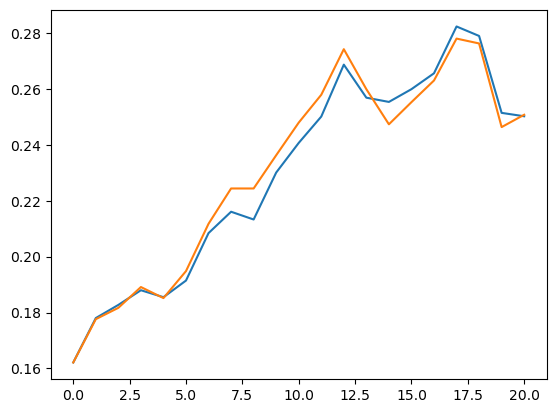

In [94]:
import matplotlib.pyplot as plt
%matplotlib inline

x = range(21)
plt.plot(x, np.nanmean(np.nanmean(datesets,axis=2),axis=1))
plt.plot(x,  np.nanmean(np.nanmean(datesets_ref,axis=2),axis=1))
plt.show()

In [ ]:
n_ensemble, reread_required = check_for_success(dir_iter,dir_DA,dir_settings,date_results_iter,n_ensemble)

In [ ]:
import importlib
import DA_operators
importlib.reload(DA_operators)
from DA_operators import operator_clm_SMAP, operator_clm_FLX

operator = {}
data_measured = {}
data_latlon = {}

# Operator for SMAP
operator['SMAP'] = operator_clm_SMAP(settings_DA['file_lsm'],settings_DA['file_corner'],settings_DA['folder_SMAP'],ignore_rivers=False)
data_measured['SMAP'],_,data_latlon['SMAP'] = operator['SMAP'].get_measurements(date_results_iter,date_DA_start=date_start_sim,return_latlon=True)

# Operator for FLUXNET
operator['FLX'] = operator_clm_FLX(settings_DA['file_lsm'],settings_DA['file_corner'],settings_DA['folder_FLX'],ignore_rivers=False)
data_measured['FLX'],data_var['FLX'],data_latlon['FLX'] = operator['FLX'].get_measurements(date_results_iter,date_DA_start=date_start_sim,return_latlon=True,variance=settings_DA['data_var']['FLX'])

# mask observations to required amount given in data_nselect
# it would be more efficient to already apply the masking in the operator.get_measurements functions
data_mask,data_indices,n_data,data_measured_masked,data_var_masked,data_latlon_masked = mask_observations(data_names,data_measured,data_var,data_latlon,data_nselect,data_mask,factor_inflate=factor_inflate)

# get most likely parameter output, to track if the iterations are improving
t0 = time.time()
_ = operator['SMAP'].interpolate_model_results(0,settings_run,indices_z=[0,1],var='SOILLIQ')#[data_mask['SMAP']]
operator['SMAP'].plot_results(i_iter,0,settings_run,indices_z=0,var='SOILLIQ',n_plots=12,dir_figs=settings_run['dir_figs'])
_ = operator['FLX'].interpolate_model_results(0,settings_run,retain_history=True)#[data_mask['FLX']]
operator['FLX'].plot_results(i_iter,0,settings_run,dir_figs=os.path.join(settings_run['dir_figs'],'FLX'))
t1 = time.time()
print('%f seconds for interpolating/plotting one ensemble member'%(t1-t0), flush=True)

In [ ]:
# 2) get the corresponding ensemble measurements ("forecast")
print('Interpolating/plotting all ensemble members...', flush=True)
t0 = time.time()
data_f = np.zeros([n_data,n_ensemble])
for i_real in np.arange(1,n_ensemble+1):   
    print('%i/%i' % (i_real,n_ensemble), flush=True)
    for var_ in data_names:
        data_f[data_indices[var_][0]:data_indices[var_][1],i_real-1] = operator[var_].interpolate_model_results(i_real,settings_run)[data_mask[var_]]
    if 'SMAP' in data_names and (plot_members_SMAP==True or plot_members_SMAP==i_iter):
        operator['SMAP'].plot_results(i_iter,i_real,settings_run,indices_z=0,var='SOILLIQ',n_plots=4)
t1 = time.time()
print('%f seconds for interpolating/plotting all ensemble members'%(t1-t0), flush=True)
print('Shape of data array (data_f):')
print(data_f.shape)

if 'FLX' in data_names and plot_members_FLX:
    operator['FLX'].plot_all_results(i_iter,settings_run,dir_figs=os.path.join(settings_run['dir_figs'],'FLX'))

print('Performing Kalman update...', flush=True)
t0 = time.time()

In [ ]:
param_a,mean_mismatch_new,alpha = update_step_ESMDA_loc(param_f,data_f,data_measured_masked,data_var_masked,alpha,i_iter,n_iter,
                                                        param_latlon=param_latlon,param_r_loc=param_r_loc,data_latlon=data_latlon_masked,ksi=ksi,
                                                        dir_settings=dir_settings,dzeta_global=settings_DA['dzeta_global'],
                                                        factor_inflate_prior=factor_inflate_prior,
                                                        loc_type=settings_DA['loc_type'],POL_eps=settings_DA['POL_eps'])
t1 = time.time()
print('%f seconds for Kalman update'%(t1-t0), flush=True)

In [ ]:
print(n_iter)

In [ ]:
# Test for func 'update_step_ESMDA_loc'

mat_M = param_f
mat_D = data_f
data_measured = data_measured_masked
data_var = data_var_masked
alpha = [27269.372843216566, 1.000036636127625]
i_iter = 0
n_iter = 2

n_data_ = mat_D.shape[0]
n_ensemble = mat_D.shape[1]
n_param = mat_M.shape[0]

C_D = sparse.diags(data_var)

del_M = (1/np.sqrt(n_ensemble-1))*(mat_M - mat_M.mean(axis=1)[:,np.newaxis])
del_D = (1/np.sqrt(n_ensemble-1))*(mat_D - mat_D.mean(axis=1)[:,np.newaxis])

del_D *= factor_inflate_prior

S = sparse.diags(C_D.diagonal()**(1/2))
C_Dh = 1.*sparse.eye(n_data_)
Sinv = sparse.diags(1/S.diagonal()) #inverse of diagonal matrix: simply the reciprocal


In [ ]:
Ud, lambda_Wd, Vdt = np.linalg.svd(Sinv.dot(del_D), full_matrices=False)
assert(np.all(lambda_Wd[:-1] > lambda_Wd[1:]))
       
cumsum_wr = np.cumsum(lambda_Wd) / np.sum(lambda_Wd)
Nr = max(len(lambda_Wd)//2, np.where(cumsum_wr<=ksi)[0][-1]) #take Nr most important singular values, retain at least half the original matrix size just in case

Ur = Ud[:,0:Nr]
Wr = sparse.diags(lambda_Wd[0:Nr])
Vrt = Vdt[0:Nr,0:Nr]
Ir = sparse.eye(Nr)
Wrinv = sparse.diags(1/Wr.diagonal()) 

mat_R = alpha[i_iter]*(Wrinv @ Ur.T @ C_Dh @ Ur @ Wrinv)

Zr, lambda_Hr, Zrt = np.linalg.svd(mat_R, full_matrices=False)
Hr = sparse.diags(lambda_Hr)

mat_X = Sinv @ Ur @ Wrinv @ Zr
mat_L = Ir + Hr
mat_Linv = sparse.diags(1/mat_L.diagonal()) 

mat_X1 = mat_Linv @ mat_X.T
mat_X2 = del_D.T @ mat_X
mat_X3 = mat_X2 @ mat_X1

# perturb observations, at the same time calculate the mismatch of the current forecast
mat_Dobs = np.zeros(mat_D.shape)
mean_mismatch_new = 0
for i_real in range(n_ensemble):
    z_d = np.random.normal(0,1,n_data_)
    mat_Dobs[:,i_real] = data_measured + np.sqrt(alpha[i_iter])*np.sqrt(C_D.diagonal())*z_d
    mismatch = mat_Dobs[:,i_real] - mat_D[:,i_real]
    mean_mismatch_new += np.sum(mismatch**2)
mean_mismatch_new /= n_ensemble


In [ ]:
sum_d_localized = 0
sum_d_global = 0
n_param_localized_tot = 0
# calculate updated (analysis) parameters

# used for POL localisation:
c_ii = np.var( (mat_M - mat_M.mean(axis=1)[:,np.newaxis]), axis=1, ddof=1) #(n_param,) -> estimate of C_M
c_jj = np.var( (mat_D - mat_D.mean(axis=1)[:,np.newaxis]), axis=1, ddof=1) #(n_data,) -> estimate of C_D

param_a = np.zeros(mat_M.shape)
for i in range(n_param):

    # first localisation option: distance based, by using haversine distance & GC function
    if loc_type == 'distance':    
        if np.isnan(param_r_loc[i]):
            rho_i = dzeta_global*np.ones(n_data_) #no localisation
        else:
            r_loc = param_r_loc[i]
            # localisation using the Gaspari-Cohn localisation function:
            rho_i = GC(haversine_distance(param_latlon[i,:],data_latlon),r_loc)
    # second option: pseudo optimal localization
    # see e.g. Lacerda et al. (2019), Furrer et al. (2007)
    elif loc_type == 'POL':
        ci = del_M[i,:]@(del_D[:,:].T)
        rho_i = ci**2 / (ci**2 + (ci**2+(c_ii[i]*c_jj)/n_ensemble) )
        mask_zero = np.abs(ci) < POL_eps*np.sqrt(c_ii[i]*c_jj)
        rho_i[mask_zero] = 0

    else:
        print('Warning!! Localisation method unknown. Set to POL or distance')
        rho_i = np.ones(n_data_)


    K_i = del_M[i,:]@mat_X3
    K_rho_i = K_i * rho_i
    mat_X4 = K_rho_i @ (mat_Dobs - mat_D)
    param_a[i,:] = mat_M[i,:] + mat_X4

In [ ]:
files_clm = sorted(glob(os.path.join(settings_run['dir_iter'],'R000/**/*.clm2.h0.*.nc')))
print(files_clm)

In [ ]:
grid_centre = xr.open_dataset('/p/project/cjibg36/jibg3674/shared_DA/EUR-11_TSMP_FZJ-IBG3_444x432_LAND-LAKE-SEA-MASK.nc',decode_times=False)


In [11]:
import numpy as np
import os
# import re
# import shutil
from datetime import datetime, timedelta
import pandas as pd
from glob import glob
import xarray as xr
# import netCDF4
import sys
from DA_operators import operator_clm_SMAP, operator_clm_FLX, haversine_distance
import matplotlib.pyplot as plt
import pickle

# folder_results = '/p/scratch/cjibg36/kaandorp2/TSMP_results/eTSMP/DA_eCLM_cordex_444x432_v13_1y_xy16_loc16_a16_dzeta04_iter3_FLXv2_inflate105'
i_iter = 2
folder_results = '/p/scratch/cjibg36/jibg3674/CLM5_DA/small_test_ap_16ens/'

sys.path.insert(0,os.path.join(folder_results,'settings'))
from settings import settings_run,settings_clm,settings_pfl,settings_sbatch,settings_DA,settings_gen,date_results_binned,freq_output,date_range_noleap



In [7]:
settings_gen

{'dir_clm_surf': '/p/scratch/cjibg36/jibg3674/CLM5_DA/small_test_ap_16ens/input_clm',
 'file_clm_surf': 'surfdata_EUR-11_hist_16pfts_Irrig_CMIP6_simyr2000_c230808_GLC2000.nc',
 'texture_sample_xy': 16,
 'texture_start_x': 8,
 'texture_start_y': 8,
 'texture_sample_z': None,
 'texture_plot': True,
 'texture_anom_l': 16,
 'texture_anom_l_bounds': 'fixed',
 'texture_nu': 0.5,
 'param_length': {},
 'perturb_frac_std': 0.1,
 'file_indi': '/p/project/cjibg36/jibg3674/shared_DA/setup_eclm_cordex_444x432_v9/input_pf/EUR-11_TSMP_FZJ-IBG3_CLMPFLDomain_444x432_INDICATOR_regridded_rescaled_SoilGrids250-v2017_BGR3_alv.sa',
 'Ks_sample_xy': 10,
 'Ks_sample_z': 5,
 'Ks_mode': 'ml',
 'Ks_plot': True,
 'a_sample_xy': 10,
 'a_sample_z': 5,
 'a_plot': True,
 'n_sample_xy': 10,
 'n_sample_z': 5,
 'n_plot': True,
 'poros_sample_xy': 10,
 'poros_sample_z': 5,
 'poros_plot': True,
 'file_slopex': '/p/project/cjibg36/jibg3674/shared_DA/setup_eclm_cordex_444x432_v9/input_pf/slopex.sa',
 'file_slopey': '/p/proj

In [12]:
dir_figs = os.path.join(folder_results,'figures/02_prior_post')
if not os.path.exists(dir_figs):
    print('Creating folder to store information: %s' % (dir_figs) )
    os.makedirs(dir_figs)
    
%matplotlib inline

def Gaussian(x,m,s):
    return (1/(s*np.sqrt(np.pi)))*np.exp(-.5*((x-m)/s)**2)

def read_paramfiles(list_files):
    for i1,file_ in enumerate(list_files):
        data = np.load(file_)
        if i1 == 0:
            array = np.zeros([0,len(data)])
        array = np.vstack((array,data))
    return array
        

Creating folder to store information: /p/scratch/cjibg36/jibg3674/CLM5_DA/small_test_ap_16ens/figures/02_prior_post


In [13]:
log_scale = {'orgmax_v2':True,
             'fff':True,
             'h2o_canopy_max':True,
             'luna':True,
             'mineral_hydraulic':False,
             'om_hydraulic':True,
             'kmax_v2':True,
             'medlyn_slope_v2':False,
             'medlyn_intercept_v2':True,
             'sandfrac_anom':True,
             'clayfrac_anom':True,
             'orgfrac_anom':True}

symbols =   {'orgmax_v2':r'$\rho_{sc,max}$',
             'fff':r'f$_{sat.decay}$',
             'h2o_canopy_max':r'H$_2$O$_{can.,max}$',
             'luna':[r'J$_{maxb0}$', r'J$_{maxb1}$', r't$_{c,j0}$', r'$H$'],
             'mineral_hydraulic':[r'$\alpha_{b,miner.}$',r'$\beta_{b,miner.}$',
                                  r'$\alpha_{\psi_s,miner.}$',r'$\beta_{\psi_s,miner.}$',
                                  r'$\alpha_{k_s,miner.}$',r'$\beta_{k_s,miner.}$',
                                  r'$\alpha_{\theta_s,miner.}$',r'$\beta_{\theta_s,miner.}$'], 
             'om_hydraulic':[r'$\theta_{s,om}$',r'$b_{om}$',
                             r'$\psi_{s,om}$',r'$k_{s,om}$',
                             r'$\Delta_{z,\theta,om}$',r'$\Delta_{z,b,om}$',
                             r'$\Delta_{z,\psi,om}$'],
             'kmax_v2':r'k$_{max},$',
             'medlyn_slope_v2':r'$\alpha_{g_s},$',
             'medlyn_intercept_v2':r'$\beta_{g_s},$',
             'sandfrac_anom':r'$\Delta_{sand}$',
             'clayfrac_anom':r'$\Delta_{clay}$',
             'orgfrac_anom':r'$\Delta_{om}$'}

figures =   {'orgmax_v2':1,
             'fff':1,
             'h2o_canopy_max':1,
             'luna':1,
             'mineral_hydraulic':2,
             'om_hydraulic':2,
             'kmax_v2':3,
             'medlyn_slope_v2':4,
             'medlyn_intercept_v2':5,
             'sandfrac_anom':6,
             'clayfrac_anom':6,
             'orgfrac_anom':6}

figs_data = {'data_mean_pr':np.array([]),
            'data_std_pr':np.array([]),
            'data_mean_po':np.array([]),
            'data_std_po':np.array([]),
            'i_fig':np.array([]),
            'log':np.array([]),
            'label':[]}

cmap=plt.cm.tab10


/tmp/ipykernel_6889/1608528683.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row_,col_].set_xticklabels([np.format_float_scientific(10**val_,precision=2,exp_digits=1,unique=False) for val_ in labels_])
/tmp/ipykernel_6889/1608528683.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row_,col_].set_xticklabels([np.format_float_scientific(10**val_,precision=2,exp_digits=1,unique=False) for val_ in labels_])
/tmp/ipykernel_6889/1608528683.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row_,col_].set_xticklabels([np.format_float_scientific(10**val_,precision=2,exp_digits=1,unique=False) for val_ in labels_])
/tmp/ipykernel_6889/1608528683.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row_,col_].set_xticklabels([np.format_float_scientific(10**val_,precision=2,exp_digits=1,unique=False) for val_ in labels_])
/tmp/ipykernel_6889/

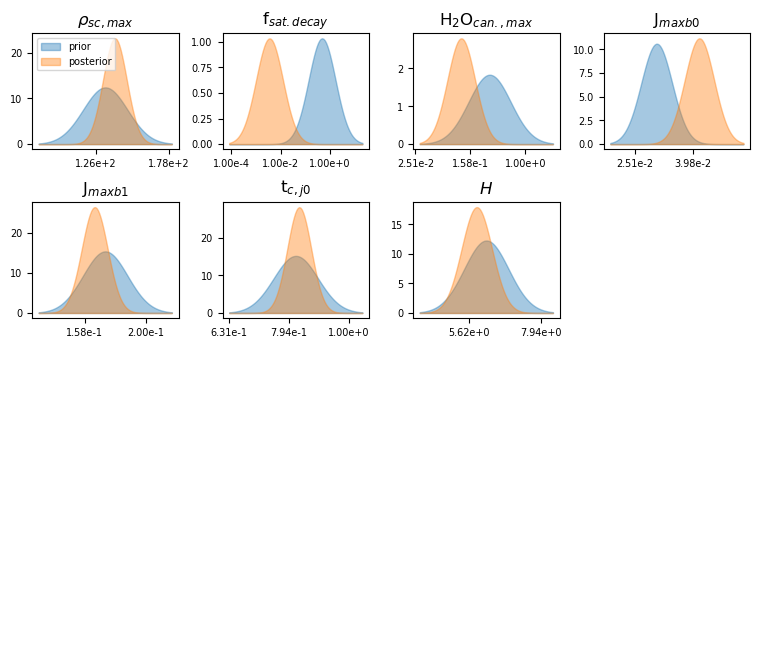

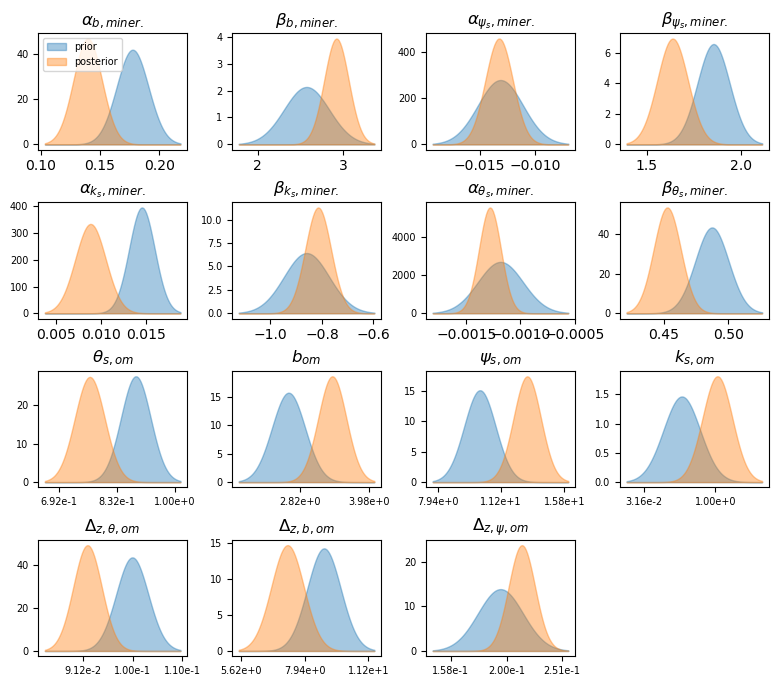

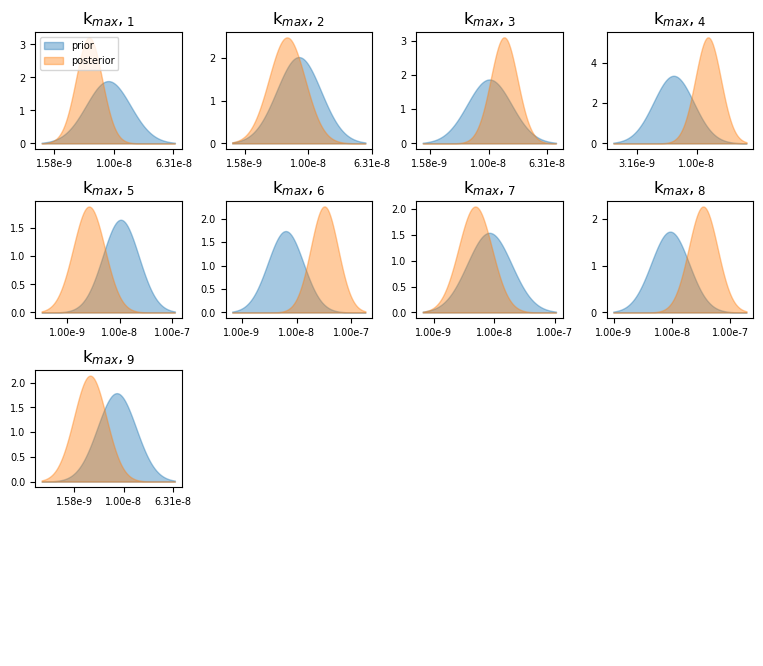

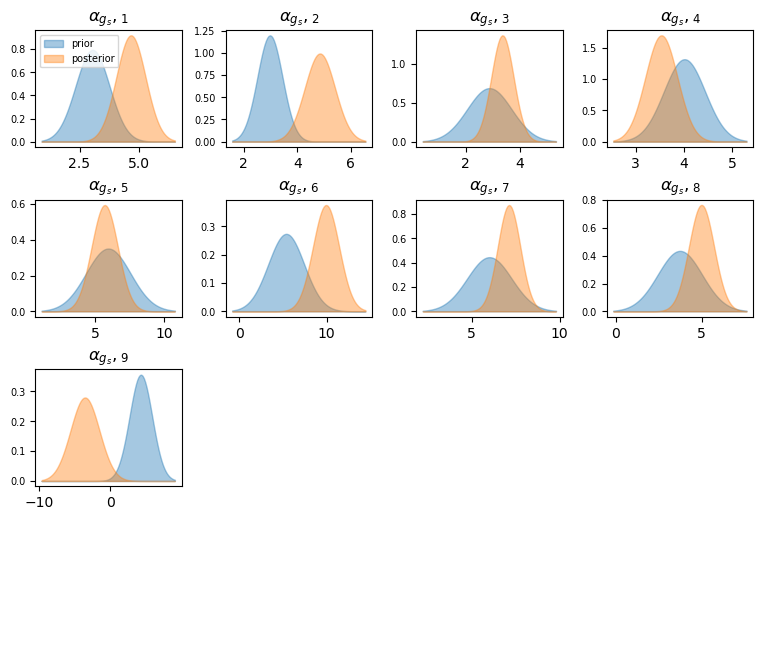

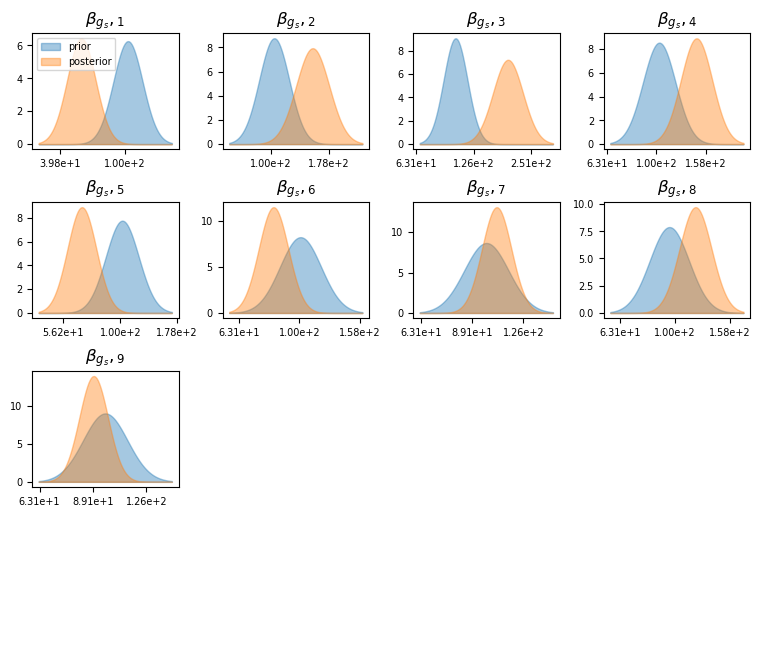

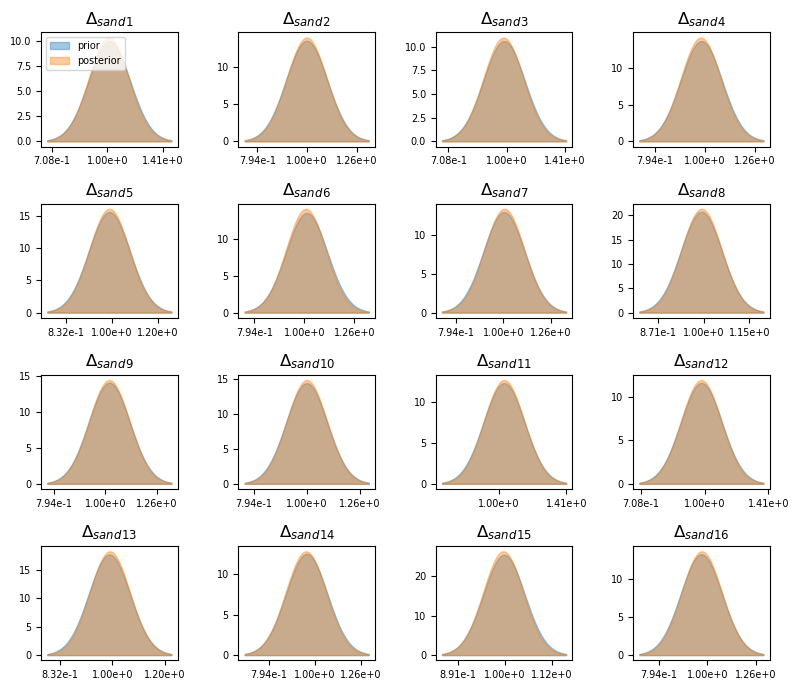

In [14]:
for param_ in figures.keys():
    # param_ = 'mineral_hydraulic'

    priors = sorted(glob(os.path.join(folder_results,'input_DA/%s.param.000.000.[0-9][0-9][0-9]*'%(param_))) )
    posteriors = sorted(glob(os.path.join(folder_results,'input_DA/%s.param.000.%3.3i.*'%(param_,i_iter))) )

    prior_vals = read_paramfiles(priors)
    post_vals = read_paramfiles(posteriors)

    figures[param_]

    figs_data['data_mean_pr'] = np.append(figs_data['data_mean_pr'], prior_vals.mean(axis=0))
    figs_data['data_std_pr'] = np.append(figs_data['data_std_pr'], prior_vals.std(axis=0))
    figs_data['data_mean_po'] = np.append(figs_data['data_mean_po'], post_vals.mean(axis=0))
    figs_data['data_std_po'] = np.append(figs_data['data_std_po'], post_vals.std(axis=0))
    figs_data['i_fig'] = np.append(figs_data['i_fig'], figures[param_]*np.ones(prior_vals.shape[1]))
    figs_data['log'] = np.append(figs_data['log'], log_scale[param_]*np.ones(prior_vals.shape[1],dtype=bool))

    if prior_vals.shape[1]==1:
        app_ = ['']
    else:
        app_ = ['$_{%i}$'%i_ for i_ in range(1,prior_vals.shape[1]+1)]
            
    if type(symbols[param_]) == str:
        list_append = [symbols[param_]+app_[i_] for i_ in range(prior_vals.shape[1])]
        figs_data['label'].extend(list_append)
    elif type(symbols[param_]) == list:
        figs_data['label'].extend(symbols[param_])
    else:
        list_append = [param_+app_[i_] for i_ in range(prior_vals.shape[1])]
        figs_data['label'].extend(list_append)
        
        
n_max=4
i_old = 0
i_fig = 0
for i1 in np.arange(len(figs_data['data_mean_pr']))[0:n_max*16+1]:
    
    if i1 == 0 or figs_data['i_fig'][i1] != i_old or c==16:
        i_old = figs_data['i_fig'][i1]
        fig,axes=plt.subplots(4,4,figsize=(8,7))
        c = 0
        
    row_ = c//4
    col_ = c%4
    
    if c == 0:
        label_pr = 'prior'
        label_po = 'posterior'
    else:
        label_pr = None
        label_po = None
        
    x_min = min( (figs_data['data_mean_pr'][i1] - 3*figs_data['data_std_pr'][i1]), 
                (figs_data['data_mean_po'][i1] - 3*figs_data['data_std_po'][i1]) )
    x_max = max( (figs_data['data_mean_pr'][i1] + 3*figs_data['data_std_pr'][i1]), 
                (figs_data['data_mean_po'][i1] + 3*figs_data['data_std_po'][i1]) )
    x_ = np.linspace(x_min,x_max,100)
    
    axes[row_,col_].fill_between(x_,Gaussian(x_,figs_data['data_mean_pr'][i1],figs_data['data_std_pr'][i1]), 
                                 y2=np.zeros_like(x_), color=cmap(0), alpha=.4, label=label_pr)
    axes[row_,col_].fill_between(x_,Gaussian(x_,figs_data['data_mean_po'][i1],figs_data['data_std_po'][i1]), 
                                 y2=np.zeros_like(x_), color=cmap(1), alpha=.4, label=label_po)
    # axes[row_,col_].plot(x_,Gaussian(x_,figs_data['data_mean_pr'][i1],figs_data['data_std_pr'][i1]),'k-')
    # axes[row_,col_].plot(x_,Gaussian(x_,figs_data['data_mean_po'][i1],figs_data['data_std_po'][i1]),'r-')
    axes[row_,col_].set_title(figs_data['label'][i1])
    axes[row_,col_].tick_params(axis='y', labelsize=7)
    if c == 0:
        axes[row_,col_].legend(fontsize=7,loc='upper left')
    
    if figs_data['log'][i1] == 1:
        axes[row_,col_].tick_params(axis='x', which='major', labelsize=7)
        axes[row_,col_].xaxis.set_major_locator(plt.MaxNLocator(3))
        labels_ = axes[row_,col_].get_xticks()
        # axes[row_,col_].set_xticklabels([r'10$^{%2.2f}$'%val_ for val_ in labels_])
        axes[row_,col_].set_xticklabels([np.format_float_scientific(10**val_,precision=2,exp_digits=1,unique=False) for val_ in labels_])
        # axes[row_,col_].tick_params(axis='x', which='major', labelsize=6)
    
    
    if i1==len(figs_data['i_fig'])-1 or c==15: 
        # fig.suptitle('Iter %i -> %i' %(i_iter,i_iter+1))
        fig.tight_layout()
        fig.savefig(os.path.join(dir_figs,'%3.3i_prior_post.pdf'%i_fig))
        i_fig+=1
        # plt.close('all')
    else: 
        if figs_data['i_fig'][i1+1] != i_old:
            # fig.suptitle('Iter %i -> %i' %(i_iter,i_iter+1))
            fig.tight_layout()
            fig.subplots_adjust(wspace=0.3,hspace=0.45)
            for c_ in range(c+1,16):
                row_ = c_//4
                col_ = c_%4
                axes[row_,col_].set_axis_off()
                
            fig.savefig(os.path.join(dir_figs,'%3.3i_prior_post.pdf'%i_fig))
            i_fig+=1
            # plt.close()
    c += 1